## Import required modules

In [36]:
import pandas as pd # Pandas for data pre-processing
import matplotlib.pyplot as plt # Matplotlib for visualizing data
import seaborn as sb
import re # Regular expression for text preprocessing
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from tqdm import tqdm
tqdm.pandas()

## Load dataset

In [2]:
train_data = pd.read_json('./data/train.json')
test_data = pd.read_json('./data/test.json')

## Data Analysis

In [3]:
train_data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
train_data['sep_ingredients'] = train_data['ingredients'].apply(','.join)
train_data.head()

,cuisine,id,ingredients,sep_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper..."


## Dataset charcteristics

In [34]:
# Count unique ingredients
ingredients_list = train_data['ingredients'].tolist()
no_unq_ing = set([ingredient for list_elem in ingredients_list for ingredient in list_elem])
no_classes = set(train_data['cuisine'].tolist())

print('Number of samples in dataset: ', train_data.shape[0])
print('Number of classes: ', len(no_classes))
print('Unique ingredients: ', len(no_unq_ing))

Number of samples in dataset:  39752
Number of classes:  20
Unique ingredients:  6714


## Ingredients in a dish

In [6]:
print("Maximum number of Ingredients in a dish: ", train_data['ingredients'].str.len().max())
print("Minimum number of Ingredients in a dish: ", train_data['ingredients'].str.len().min())

Maximum number of Ingredients in a dish:  65
Minimum number of Ingredients in a dish:  1


Text(0.5,1,'Ingredients in a Dish Distribution')

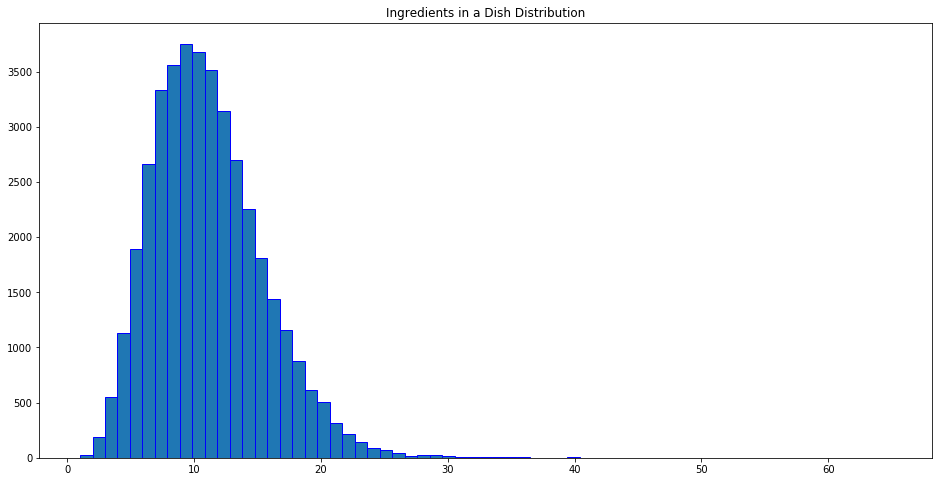

In [7]:
%matplotlib inline
plt.hist(train_data['ingredients'].str.len(), bins=max(train_data['ingredients'].str.len()), edgecolor='b')
plt.gcf().set_size_inches(16, 8)
plt.title('Ingredients in a Dish Distribution')

Text(0.5,1,'Cuisine Distribution')

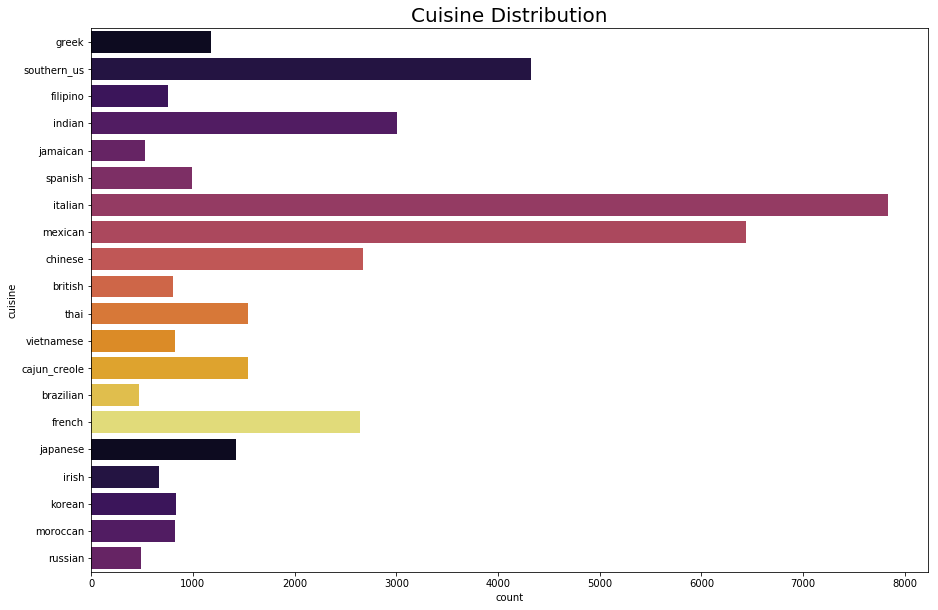

In [8]:
sb.countplot(y='cuisine', data=train_data, palette=sb.color_palette('inferno', 15))
plt.gcf().set_size_inches(15, 10)
plt.title('Cuisine Distribution', size=20)

## Investigating main ingredients 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=lambda x:[i.strip() for i in x.split(',')], lowercase=False)
counts = vec.fit_transform(train_data['sep_ingredients'])
count = dict(zip(vec.get_feature_names(), counts.sum(axis=0).tolist()[0]))
count = pd.DataFrame(list(count.items()), columns=['Ingredient', 'Count'])

Text(0.5,1,'Top 15 Ingredients')

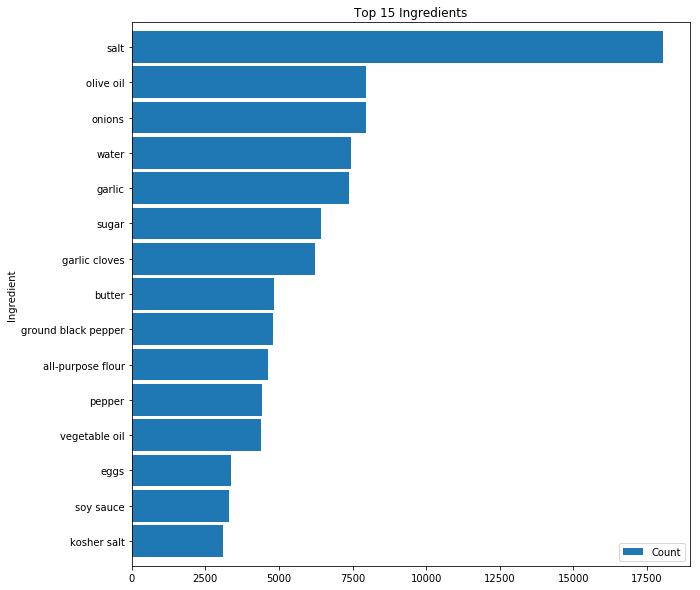

In [10]:
# Plotting Top 15 ingredints
count.set_index('Ingredient').sort_values('Count', ascending=False)[:15].plot.barh(width=0.9)
plt.gcf().set_size_inches(10, 10)
plt.gca().invert_yaxis()
plt.title('Top 15 Ingredients')

## Remove outliers

In [13]:
# Filter single-ingredients recipes
train_data['num_ingredients'] = train_data['ingredients'].apply(len)
train_data = train_data[train_data['num_ingredients'] > 1]
print('Number of samples in dataset: ', train_data.shape[0])

Number of samples in dataset:  39752


## Preprocessing

In [25]:
lemmatizer = WordNetLemmatizer()

def preprocess(ingredients):
    
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower()
    ingredients_text = ingredients_text.replace('-', ' ')
    
    words = []
    
    for word in ingredients_text.split():
        
        # remove numbers
        if re.findall('[0-9]', word): continue
        
        # remove words that consis of less than 2 characters
        if len(word) <= 2: continue
            
        if '’' in word: continue
            
        word = lemmatizer.lemmatize(word)
        if len(word) > 0: words.append(word)
            
    return ' '.join(words)

# Testing the preprocess function
for ingredient, expected in [('Eggs', 'egg'),
    ('all-purpose flour', 'all purpose flour'),
    ('purée', 'purée'),
    ('1% low-fat milk', 'low fat milk'),
    ('half & half', 'half half'),
    ('safetida (powder)', 'safetida (powder)')
]:
    
    actual = preprocess([ingredient])
    print('Expected: ', expected, 'Actual: ', actual)
    assert actual == expected, f'{expected} is expected but got {actual}'

Expected:  egg Actual:  egg
Expected:  all purpose flour Actual:  all purpose flour
Expected:  purée Actual:  purée
Expected:  low fat milk Actual:  low fat milk
Expected:  half half Actual:  half half
Expected:  safetida (powder) Actual:  safetida (powder)


In [31]:
train_data['sep_ingredients'] = train_data['ingredients'].progress_apply(preprocess)
test_data['sep_ingredients'] = test_data['ingredients'].progress_apply(preprocess)
train_data.head()

100%|████████████████████████████████████████████████████████████████████████████| 9944/9944 [00:01<00:00, 7788.24it/s]


,cuisine,id,ingredients,sep_ingredients,num_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olive grape tomato garli...,9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomato ground b...,11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",egg pepper salt mayonaise cooking oil green ch...,12
3,indian,22213,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt,4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallot cornflour cayenne pepper ...,20


## Feature extraction with TFIDF

In [43]:
vectorizer = make_pipeline(TfidfVectorizer(sublinear_tf=True),
                          FunctionTransformer(lambda x: x.astype('float16'), validate=False))

x_train = vectorizer.fit_transform(train_data['sep_ingredients'].values)
x_train.sort_indices()
x_test = vectorizer.transform(test_data['sep_ingredients'].values)